# 3 微积分
## 3.1 导数和微分
函数$f:\mathbb R\to\mathbb R$，其输入和输出都是标量。如果f的导数存在，这个极限被定义为：
$$
f'(x)=\lim_{h\to 0}\frac{f(x+h)-f(x)}{h}
$$
如果$f'(a)$存在，则称f在a处可微（differentiable）

导数的几个等价符号
$$
f'(x)=y'=\frac{\mathrm dy}{\mathrm dx}=\frac{\mathrm df}{\mathrm dx}=\frac{\mathrm d}{\mathrm dx}f(x)=\mathrm Df(x)=\mathrm D_xf(x)
$$

In [1]:
def f(x):
    return 3 * x ** 2 - 4 * x

def numerical_lim(f, x, h):
    return (f(x+h)-f(x)) / h

h = 0.1

for i in range(5):
    print(f"h={h:.5f},numerical limit={numerical_lim(f,1,h):.5f}")
    h *= 0.1

h=0.10000,numerical limit=2.30000
h=0.01000,numerical limit=2.03000
h=0.00100,numerical limit=2.00300
h=0.00010,numerical limit=2.00030
h=0.00001,numerical limit=2.00003


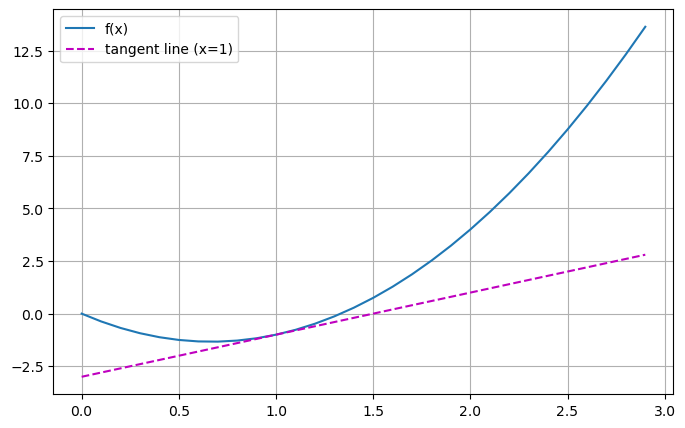

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 3, 0.1)
plt.figure(figsize=(8, 5))
plt.plot(x,f(x),label="f(x)")
plt.plot(x,2*x-3,'m--',label="tangent line (x=1)")
plt.grid()
plt.legend()
plt.show()

## 3.2 偏导数

设$y=f(x_1,x_2,...,x_n)$是一个具有n个变量的函数。y关于第i个参数$x_i$的偏导数（partial derivative）为：
$$
\frac\partial y\partial x_i=\lim_{h\to 0}\frac{f(x_1,...,x_i+h,...,x_n) - f(x_1,...,x_i,...,x_n)}{h}
$$

对于偏导数的表示，以下等价
$$
\frac{\partial y}{\partial x_i}=\frac{\partial f}{\partial x_i}=f_{x_i}=f_i=\mathrm D_if=\mathrm D_{x_i}f
$$

## 3.3 梯度 
连结一个多元函数对齐所有变量的偏导数，以得到该函数的梯度（gradient）向量。设函数$f:\mathbb R^n\to R$的输入是一个n维向量$\mathbf x=[x_1,x_2,...,x_n]^\top$，并且输出是一个标量。函数$f(\mathbf x)$对于$\mathbf x$的梯度是一个包含n个偏导数的向量：
$$
\nabla_xf(x)=[\frac{\partial(f\mathbb x)}{\partial x_1},\frac{\partial f(\mathbb x)}{x_2},...,\frac{\partial f(\mathbb x)}{x_n}]
$$

$\nabla_x f(\mathbf x)$在没有歧义时被$\nabla f(\mathbf x)$取代

- $\forall\mathbf A\in\mathbb R^{n\times n},\nabla_x\mathbf{a^\top Ax=(A+A^\top) x} $

## 3.4 链式法则
深度学习中，多元函数通常是复合的（composite），可以用链式法则来微分复合函数：
$$
\frac{\partial y}{\partial x_i}=\frac{\partial y}{\partial u_1}\frac{\partial u_1}{\partial x_i}+\frac{\partial y}{\partial u_2}\frac{\partial u_2}{\partial x_i}+...+\frac{\partial y}{\partial u_m}\frac{\partial u_m}{\partial x_i}
$$

# 3.5 自动微分
深度学习框架通过自动计算，即自动微分（automatic differentiation）来加快求导。实际中，根据设计好的一个模型，系统会构建一个计算图（computational graph），来跟踪计算式哪些数据通过哪些操作组合起来产生输出。自动微分系统随后反向传播梯度。反向传播（backpropagate）意味着跟踪整个计算图，填充每个参数的偏导数。

In [5]:
import torch
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

计算梯度之前需要空间存储梯度，不需要每次对一个参数求导时分配新的内存。一个标量函数关于向量$\mathbf x$的梯度时向量，并且与$\mathbf x$具有相同的形状

In [10]:
x.requires_grad_(True) # 等价于x = torch.arange(4.0, requires_grad=True)
print(x.grad) # 默认为None

y = 2 * torch.dot(x,x)
print(y)

# 反向传播
y.backward()
print(x.grad)
print(x.grad == 4 * x)

None
tensor(28., grad_fn=<MulBackward0>)
tensor([ 0.,  4.,  8., 12.])
tensor([True, True, True, True])


In [14]:
# 默认情况下，PyTorch会累计梯度，需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

### 非标量变量的反向传播

当y不是标量时，向量y关于向量x的导数的最自然解释是一个矩阵。对于高阶和高维的x和y，求导的结果可以是一个高阶张量

In [16]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度
x.grad.zero_()
y = x * x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

### 分离计算

希望将某些计算移动到记录的计算图之外。梯度不会流经中间变量到x

In [22]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x
z.sum().backward()
x.grad,u

(tensor([0., 1., 4., 9.]), tensor([0., 1., 4., 9.]))

In [23]:
x.grad.zero_()
y.sum().backward()
x.grad, 2 * x

(tensor([0., 2., 4., 6.]), tensor([0., 2., 4., 6.], grad_fn=<MulBackward0>))

### Python控制流的梯度计算
自动微分的好处：即使构建函数的计算图需要通过Python控制流，仍然可以计算得到变量的梯度。

In [25]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(),requires_grad=True)
d = f(a)
d.backward()

a.grad, d / a

(tensor(204800.), tensor(204800., grad_fn=<DivBackward0>))